<h1 align="center">Projet de machine learning - Notebook Python</h1>
<h4 align="center">Albane Vergnes, Maïlys Feuillerat, Estelle brunel, Noémie Rouchon</h4>

Dans ce notebook, nous appliquons différentes techniques de machine learning au jeu de données intitulé "Gym Members Exercise Dataset". L’objectif initial est de se familiariser avec ce jeu de données à travers une analyse exploratoire approfondie, incluant une étude univariée, bivariée, ainsi qu'une analyse en composantes principales (ACP).

Dans un second temps, l’accent sera mis sur la prédiction de deux variables cibles :

- Calories_burned (variable quantitative)
- Experience_Level (variable qualitative à trois modalités)

Pour chacune, nous chercherons à identifier les modèles prédictifs les plus performants. Dès que cela sera pertinent, nous établirons des liens explicites entre les observations issues de l’analyse exploratoire et les résultats des modèles de prédiction, afin d’enrichir l’interprétation globale.

Ce notebook est codé en language Python et la liste des packages utilisés est donnée ci-dessous:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
import seaborn as sns

from sklearn.model_selection import train_test_split , GridSearchCV ,cross_val_predict
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, classification_report, auc
from sklearn.linear_model import LinearRegression, Ridge,LogisticRegression
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor,plot_tree
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.multiclass import OneVsRestClassifier

# Analyse exploratoire des données (faite en R)

Avant de commencer la modélisation de variables d'intérêt, il était nécessaire de réaliser une analyse exploratoire de nos données. Dans notre cas, nous nous intéressons à des données sur les membres d'une salle de Gym. Des analyses unidimensionelles, multidimensionelles ainsi que de la réduction de dimension par ACP ont été réalisées en R. Nous nous baserons sur celles-ci pour les transformations suivantes.

In [2]:
# Chargement des données

Gym = pd.read_csv("Donnees_projet.csv")

# Conversion des colonnes en catégories (équivalent à factor en R)
Gym['Gender'] = Gym['Gender'].astype('category')
Gym['Workout_Type'] = Gym['Workout_Type'].astype('category')
Gym['Workout_Frequency'] = Gym['Workout_Frequency (days/week)'].astype('category')
Gym['Experience_Level'] = Gym['Experience_Level'].astype('category')

# Renommage des colonnes pour simplifier l'accès
Gym['Session_Duration'] = Gym['Session_Duration (hours)']
Gym['Water_Intake'] = Gym['Water_Intake (liters)']

#Transformation racine carré
Gym["BMI"]=Gym["BMI"].map(lambda x: np.sqrt(x))

# Sélection des colonnes d'intérêt
Gym = Gym.iloc[:, [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 13, 14, 15, 16, 17]]

# Affichage des premières lignes et résumé statistique
print(Gym.head())
print(Gym.describe(include='all'))

   Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0   56    Male         88.3        1.71      180      157           60   
1   46  Female         74.9        1.53      179      151           66   
2   32  Female         68.1        1.66      167      122           54   
3   25    Male         53.2        1.70      190      164           56   
4   38    Male         46.1        1.79      188      158           68   

   Calories_Burned Workout_Type  Fat_Percentage Experience_Level       BMI  \
0           1313.0         Yoga            12.6                3  5.495453   
1            883.0         HIIT            33.9                2  5.656854   
2            677.0       Cardio            33.4                2  4.970915   
3            532.0     Strength            28.8                1  4.290688   
4            556.0     Strength            29.2                1  3.793415   

  Workout_Frequency  Session_Duration  Water_Intake  
0                 4             

 Les remarques principales de notre analyse exploratoire sont les suivantes :
 - On observe une forte corrélation positive entre les calories brûlées et la durée de la session ainsi qu'une corrélation (moins importante) avec l'hydratation.
 - Des variables comme l'âge, le max_BPM ou l'avg_BPM ont une corrélation faible avec les autres variables suggérant éventuellement un faible impact dans notre analyse.
 - Les différents niveau d'experiences se démarquent par la durée des session ainsi que la quantité de calories brûlées qui sont plus importantes pour un niveau d'experience avancé. Le niveau intermédiaire semble se distinguer légèrement moins du niveau débutant bien que lui aussi coincide avec des sessions plus longues et intensives.
 - On retrouve sur l'ACP que la modalité niveau d'experience avancé se démarque particulièrement des deux autres modalités possibles.

# Prévision des calories brûlées

Dans cette partie, nous avons pour objectif de prédire la quantitée de calories brûlées par rapport aux autres variables explicatives à notre disposition. Pour cela, nous allons tester plusieurs modèles de regression et comparer leur efficacité. Pour la suite chaque variable explicative qualitative sera transformée en plusieurs variables binaires (une par modalité) par One-Hot encoding. 

In [3]:
#One-Hot encodage
GymDum=pd.get_dummies(Gym[["Gender","Workout_Type","Experience_Level","Workout_Frequency"]])  #Variables qualitatives encodées
GymDum = GymDum.drop(columns=["Workout_Type_Cardio","Experience_Level_1","Workout_Frequency_2"])
GymQuant= Gym.select_dtypes(include=['int64', 'float64'])  #Variables quantitatives

#Création de la base pour la prévision
dfC=pd.concat([GymDum,GymQuant],axis=1)
dfC=dfC.drop(columns=["Calories_Burned"])
dfC.head()

,Gender_Female,Gender_Male,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga,Experience_Level_2,Experience_Level_3,Workout_Frequency_3,Workout_Frequency_4,Workout_Frequency_5,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Fat_Percentage,BMI,Session_Duration,Water_Intake
0,False,True,False,False,True,False,True,False,True,False,56,88.3,1.71,180,157,60,12.6,5.495453,1.69,3.5
1,True,False,True,False,False,True,False,False,True,False,46,74.9,1.53,179,151,66,33.9,5.656854,1.30,2.1
2,True,False,False,False,False,True,False,False,True,False,32,68.1,1.66,167,122,54,33.4,4.970915,1.11,2.3
3,False,True,False,True,False,False,False,True,False,False,25,53.2,1.70,190,164,56,28.8,4.290688,0.59,2.1
4,False,True,False,True,False,False,False,True,False,False,38,46.1,1.79,188,158,68,29.2,3.793415,0.64,2.8


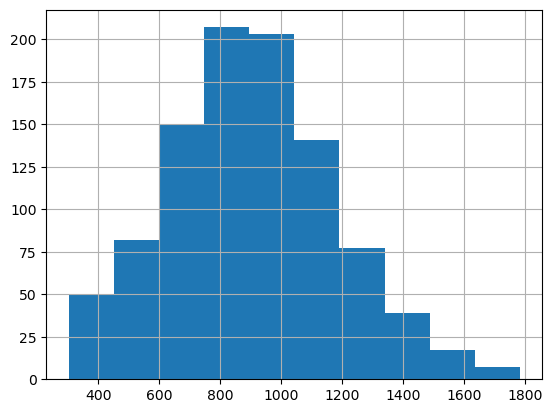

In [4]:
# variable à expliquer réelle
Y=Gym["Calories_Burned"]
Y.hist()
plt.show()

## Séparation de la base en train/test

Nous séparons d'abord nos données en deux echantillons: l'échantillon d'apprentissage (X_train) et l'échantillon de test (X_test).
- L'échantillon d'apprentissage comprend à 80% de la base complète. Il permet d'entraîner un modèle sur les données qui lui sont fournies. On l'utilisera également pour estimer les paramètres optimaux des modèles.
- L'échantillon de test permettra d'appliquer notre modèle entraîné à de nouvelles variables afin de calculer l'erreur de généralisation. Ainsi, on pourra comparer les différentes méthodes entre elles.

On normalise ensuite les données sur les variables explicatives; Certaines méthodes le nécessitant.

In [5]:
X_train,X_test,Y_train,Y_test=train_test_split(dfC,Y,test_size=0.2,random_state=11)

In [6]:
# Normalisation des variables explicatives
scaler = StandardScaler()  
scaler.fit(X_train)  
Xr_train = scaler.fit_transform(X_train)  
Xr_test = scaler.transform(X_test)

## Modèles linéaires


On s'interesse d'abord aux modèles de type linéaires. Ceux-ci sont vastement utilisés pour leur simplicité et interpretabilité. Nous les comparerons entre eux à la fin de cette partie. La régression linéaire cherche à ajuster une droite (ou un hyperplan en cas de plusieurs variables) aux données de manière à minimiser l'erreur entre les prédictions du modèle et les valeurs réelles. 

L’objectif est de trouver les coefficients optimaux qui permettent de prédire la sortie à partir des entrées en suivant l'équation :  
$$
Y_i = \beta_0 + \beta_1 X_{i}^{1} + \beta_2 X_{i}^{2} + \cdots + \beta_p X_{i}^{p} + \varepsilon_i, \quad i = 1, 2, \dots, n
$$
où $Y_i$ est la variable à prédire, $X_{i}^{1}$ à $X_{i}^{p}$ sont les variables explicatives pour l'observation $i$, $\beta_0$ à $\beta_p$ sont les coefficients du modèle et $\varepsilon_i$ représente le bruit aléatoire.


### Sans Pénalisation

In [7]:
# Régression linéaire sans pénalisation
regLin = LinearRegression()

# Entraîner sur tout le train, prédire sur le test
regLin.fit(Xr_train, Y_train)
# Prédiction sur le train
PrevLR_train = regLin.predict(Xr_train)
# Prédiction sur les données de test
PrevLR = regLin.predict(Xr_test)
# Evaluation
Q2_LR= r2_score(Y_test, PrevLR)
r2_train= r2_score(Y_train, PrevLR_train)

n_train = len(Y_train)
n_test = len(Y_test)        # nombre d'observations
p = Xr_train.shape[1]  # nombre de variables explicatives (prédicteurs)

R2_ajuste = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)
mse_test_LR = mean_squared_error(Y_test, PrevLR)

print(f"R²-ajusté sur train = {R2_ajuste:.4f}")
print(f"Q² (R² sur test) = {Q2_LR:.4f}")
print(f"MSE sur test = {mse_test_LR:.4f}")

R²-ajusté sur train = 0.9782
Q² (R² sur test) = 0.9813
MSE sur test = 1594.5484


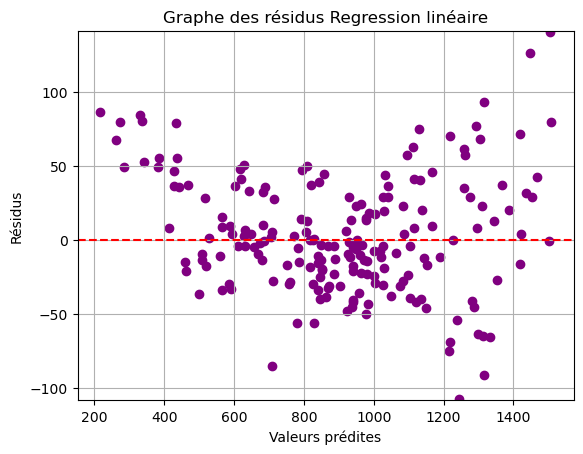

In [8]:
# Calcul des résidus
residusLR = Y_test - PrevLR

# Tracé du graphe des résidus
plt.scatter(PrevLR, residusLR, color='purple')
plt.axhline(y=0, color='red', linestyle='--')  # Ligne horizontale à y=0
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphe des résidus Regression linéaire")

plt.ylim(min(residusLR) - 1, max(residusLR) + 1) 
plt.grid(True)
plt.show()

En affichant le graphique des résidus on remarque une forme "en banane" synonyme d'un modèle peu fiable. En effet, si le modèle était bon nous observerions une ligne droit proche de la ligne y=0. Cela confirme que le modèle de régression linéaire sans pénalisation ni sélection de variable n'est pas très efficace pour la prédiction des calories brulées.

### Avec pénalisation

Il est nécessaire de trouver un équilibre entre le biais et la variance. En effet dans certaines situation, il est préférable de chosisir un modèle biaisé qui permet de réduire de manière importante la variance que de choisir un modèle surajusté. A cet effet, nous allons utiliser différents critères de pénalisation sur les modèles trop complexes. 

Pour ces modèles, on devra d'abord trouver le paramètre de pénalisation optimal. Pour cela, on effectue des cross-validation de 5 folds sur l'échantillon d'apprentissage. En python, cette validation croisée est effectuée par GridSearchCV(). 

On prédit ensuite la variable réponse pour l'échantillon test. Différents scores pour l'évaluation des modèles sont affichés et seront expliqués et analysés par la suite.

#### Sans selection de variable (Ridge)

In [9]:
regRidge = Ridge()

# Grille de valeurs pour alpha (la pénalisation)
alphas = np.linspace(0.01, 10, 100)
param = {'alpha': alphas}
regRidge = GridSearchCV(regRidge, param, cv=5, n_jobs=-1)
regRidgeOpt = regRidge.fit(Xr_train, Y_train)

# paramètre optimal
alpha_opt = regRidgeOpt.best_params_["alpha"]
print("Meilleur paramètre = %s" % (regRidgeOpt.best_params_))

Meilleur paramètre = {'alpha': 0.9181818181818182}


In [10]:
regRidge = Ridge(alpha=alpha_opt)

# Entraîner sur tout le train, prédire sur le test
regRidge.fit(Xr_train,Y_train)
PrevRidge=regRidge.predict(Xr_test)
PrevRidge_train=regRidge.predict(Xr_train)

# Evaluation
Q2_Ridge= r2_score(Y_test, PrevRidge)
r2_train= r2_score(Y_train, PrevRidge_train)

n_train = len(Y_train)
n_test = len(Y_test)        # nombre d'observations
p = Xr_train.shape[1]  # nombre de variables explicatives (prédicteurs)

R2_ajuste = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)
mse_test_Ridge = mean_squared_error(Y_test, PrevRidge)

print(f"R²-ajusté sur train = {R2_ajuste:.4f}")
print(f"Q² (R² sur test) = {Q2_Ridge:.4f}")
print(f"MSE sur test = {mse_test_Ridge:.4f}")

R²-ajusté sur train = 0.9782
Q² (R² sur test) = 0.9813
MSE sur test = 1589.2928


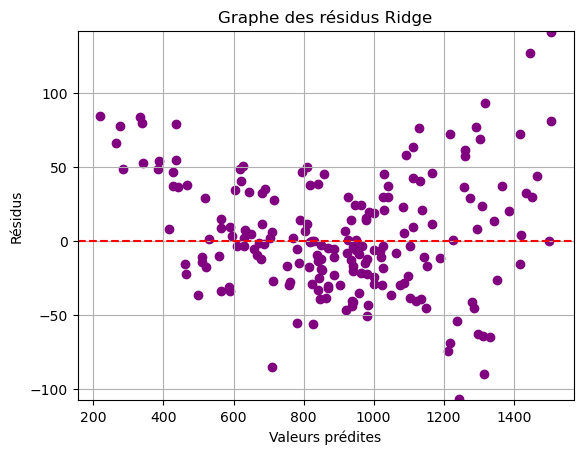

In [11]:
# Calcul des résidus
residusRidge = Y_test - PrevRidge

# Tracé du graphe des résidus
plt.scatter(PrevRidge, residusRidge, color='purple')
plt.axhline(y=0, color='red', linestyle='--')  # Ligne horizontale à y=0
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphe des résidus Ridge")

plt.ylim(min(residusRidge) - 1, max(residusRidge) + 1) 
plt.grid(True)
plt.show()

On observe de nouveaux des résidus en bananes. La pénalisation Ridge ne semble pas avoir résolue ce problème. On cherche donc d'autres manières d'améliorer notre modèle linéaire.

#### Avec sélection de variable 

Ridge ajoute une pénalité basée sur la somme des carrés des coefficients (L2), ce qui les réduit sans jamais les annuler totalement. En revanche, Lasso applique une pénalité sur la somme des valeurs absolues (L1), ce qui peut conduire à annuler complètement certains coefficients. Ainsi, Lasso permet une sélection automatique de variables, contrairement à Ridge qui conserve toutes les variables avec des poids réduits.

La sélection de variables est intéressante car elle permet de simplifier le modèle tout en conservant les variables les plus pertinentes. Cela améliore souvent les performances en évitant le surapprentissage, surtout quand certaines variables n’apportent que du bruit. En plus, un modèle avec moins de variables est plus facile à interpréter et à utiliser.

**LASSO**

In [12]:
# grille de valeurs du paramètre alpha à optimiser
param=[{"alpha":np.linspace(0.05, 5, 1000) }]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(Xr_train, Y_train)
# paramètre optimal
alpha_opt = regLassOpt.best_params_["alpha"]
print("Meilleur paramètre = %s" % (regLassOpt.best_params_))

Meilleur paramètre = {'alpha': 1.2045045045045046}


En python, nous sommes obligé de reréaliser l'ajustement du modèle car GridSearchCV ne permet pas de garder les coefficients du modèles. Pour l'analyse nous avons donc besoin d'utiliser linear_model.Lasso directement. Nous affichons les coefficients pour chaque variable après pénalisation du modèle.

Lasso conserve 12 variables et en supprime 8


Text(0.5, 1.0, 'Coefficients du modèle lasso')

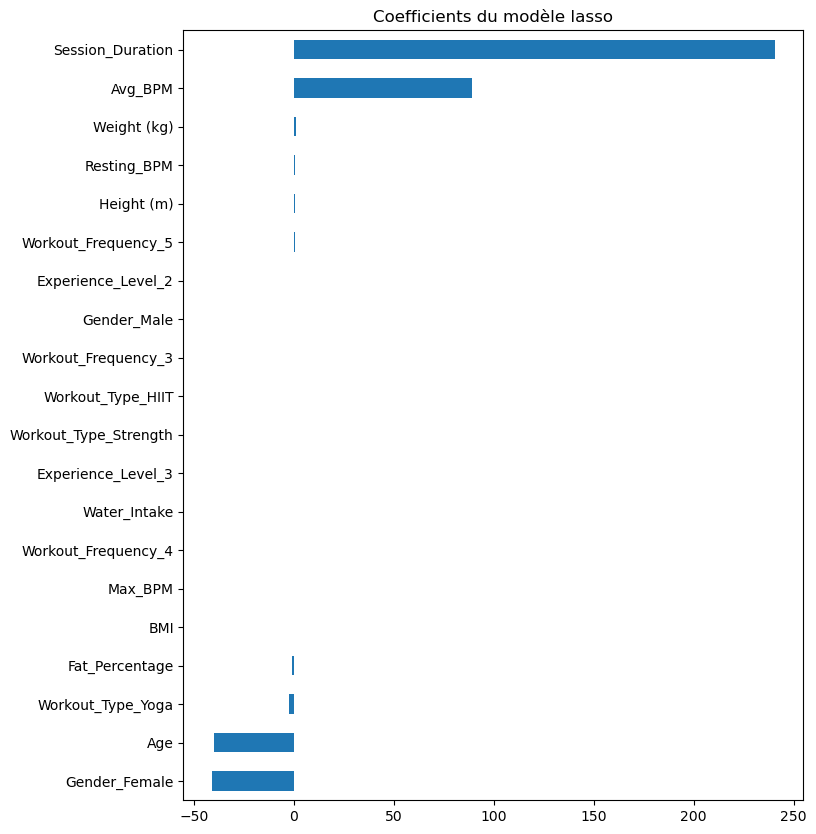

In [13]:
regLasso=linear_model.Lasso(alpha=regLassOpt.best_params_['alpha'])

# Entraîner sur tout le train, prédire sur le test
model_lasso=regLasso.fit(Xr_train,Y_train)
PrevLasso=regLasso.predict(Xr_test)
PrevLasso_train=regLassOpt.predict(Xr_train)

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

D'apres ce critère, les variables les plus interessantes pour prédire les calories brûlées sont la durée de la session, le BPM moyen, le genre (Pour éviter les redondances, la modalitée principale gardée est le sexe féminin) et l'âge. 

Comme le suggérait déjà notre analyse exploratoire, la durée de la session apparaît comme le facteur ayant l’impact le plus marqué sur les calories brûlées. Ce résultat est intuitif : plus une session est longue, plus l’énergie dépensée (et donc les calories brûlées) est élevée.

In [14]:
# Evaluation
Q2_Lasso= r2_score(Y_test, PrevLasso)
r2_train= r2_score(Y_train, PrevLasso_train)

n_train = len(Y_train)
n_test = len(Y_test)        # nombre d'observations
p = sum(coef != 0)  # nombre de variables explicatives (prédicteurs)

R2_ajuste = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)
mse_Lasso = mean_squared_error(Y_test, PrevLasso)

print(f"R²-ajusté sur train = {R2_ajuste:.4f}")
print(f"Q² (R² sur test) = {Q2_Lasso:.4f}")
print(f"MSE sur test = {mse_Lasso:.4f}")

R²-ajusté sur train = 0.9780
Q² (R² sur test) = 0.9814
MSE sur test = 1585.2333


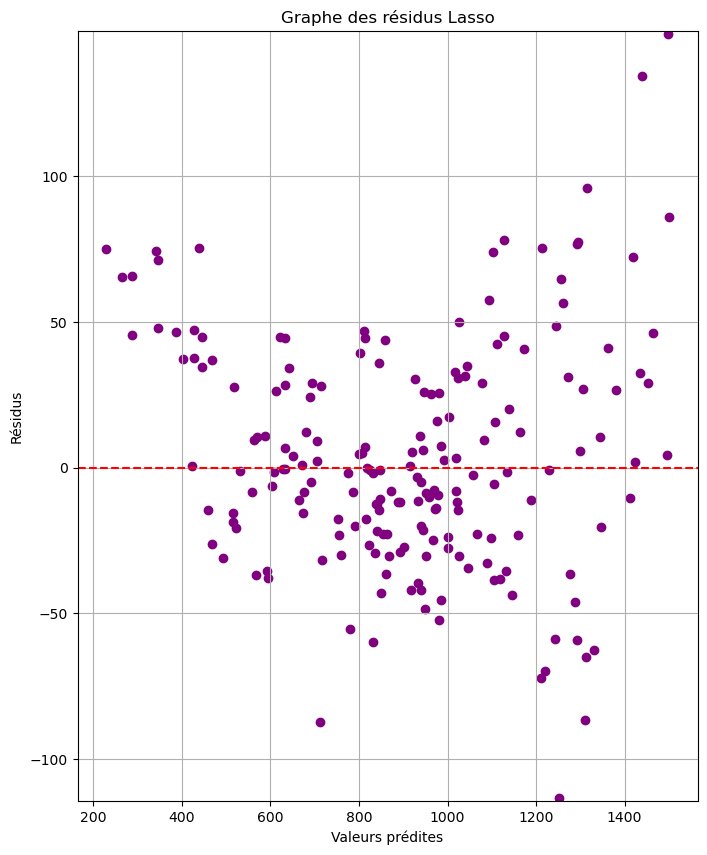

In [15]:
# Calcul des résidus
residusLasso = Y_test - PrevLasso

# Tracé du graphe des résidus
plt.scatter(PrevLasso, residusLasso, color='purple')
plt.axhline(y=0, color='red', linestyle='--')  # Ligne horizontale à y=0
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphe des résidus Lasso")

plt.ylim(min(residusLasso) - 1, max(residusLasso) + 1) 
plt.grid(True)
plt.show()

Cette pénalisation bien que plus intéressante pour l'analyse que Ridge ne résout pas le problème des résidus. Mais globalement sur les deux derniers modèles on remarque une erreur de généralisation légerement plus faible. Les modèles semblent donc plus fiables. 

**Cp/AIC/BIC**

En python, il n'est pas possible d'utiliser ces méthodes de sélection de variable. En effet, sklearn ne propose pas directement de sélection par AIC. Nous nous refererons donc à notre notebook R pour cette méthode.

### Comparaison des résidus

Les graphiques des résidus nous donnent un bon aperçu de la qualité d’ajustement des différents modèles. Pour le modèle de régression linéaire classique, on observe comme expliqué précedemment une forme en "banane" assez marquée : cela indique que les erreurs ne sont pas réparties de manière homogène. En comparaison, les modèles Lasso (pénalité L1) et Ridge (pénalité L2) montrent des résidus légèrement plus centrés et plus homogènes, ce qui témoigne d’un meilleur ajustement global. Concernant les modèles obtenus par sélection via le critère AIC (backward), les résultats sont assez proches de la régression linéaire simple (résultats sur R) : on retrouve la même courbure dans les résidus, signe que le problème initial n’a pas été totalement corrigé. Globalement, ce sont donc les approches pénalisées (surtout Ridge et Lasso) qui paraissent les plus fiables pour ce jeu de données bien que la courbure en banane soit encore légerement présente.

Nous avons décidé de comparer les $Q^2$ des différents modèles à la fin de notre analyse sur la variable Calories_burned afin de pouvoir prendre en compte aussi les $Q^2$  des modèles qui suivent.

## Support Vector Regression

On s'intéresse ensuite à la SVR, une méthode inspirée des machines à vecteurs de support (SVM) adaptée aux problèmes de régression. Elle est particulièrement utile lorsque les données ne suivent pas une distribution linéaire classique ou sont bruitées. 

Contrairement à la régression linéaire classique, la SVR cherche à ajuster une fonction (souvent linéaire ou non linéaire via un noyau) en tolérant une marge d’erreur $\varepsilon$ autour des prédictions, tout en minimisant la complexité du modèle.

Le modèle SVR linéaire s’écrit de la forme :

$$
f(X_i) = \langle w, X_i \rangle + b = w_1 X_{i}^{1} + w_2 X_{i}^{2} + \cdots + w_p X_{i}^{p} + b
$$

où $X_i$ est le vecteur des variables explicatives pour l'observation $i$, $w_1$ à $w_p$ sont les poids associés aux variables, et $b$ est le biais. Le modèle cherche à ce que les prédictions $f(X_i)$ soient à une distance au plus $\varepsilon$ de la vraie valeur $Y_i$, tout en réduisant la norme $\|w\|$ pour éviter le surapprentissage.


Afin d’identifier le modèle SVR le plus performant, plusieurs noyaux (fonctions de transformation des données) ainsi que différentes valeurs des hyperparamètres gamma et epsilon sont testés à l’aide d’une validation croisée.

- Le noyau (comme linéaire, polynomial, ou RBF) permet de projeter les données dans un espace où la relation entre les variables est plus facilement modélisable.
- Le paramètre gamma contrôle l’influence d’un seul point d’apprentissage : une petite valeur signifie une influence lointaine, tandis qu’une valeur élevée restreint cette influence à proximité immédiate.
- Le paramètre epsilon définit une zone de tolérance autour des prédictions dans laquelle les erreurs ne sont pas pénalisées, ce qui influence la sensibilité du modèle en régression.

In [16]:
param_grid = {
    "C": [0.1, 1, 10, 100],
    "epsilon": [0.01, 0.1, 0.5],
    "kernel": ["rbf","linear","poly"],
    "gamma": ["scale", 0.01, 0.02, 0.1, 1]
}

#param=[{"C":[0.4,0.5,0.6,0.8,1,1.4, 1.8]}]
svm= GridSearchCV(SVR(),param_grid,cv=10,n_jobs=-1)
svmOpt=svm.fit(Xr_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - svmOpt.best_score_,svmOpt.best_params_))

Meilleur score = 0.022674, Meilleur paramètre = {'C': 100, 'epsilon': 0.5, 'gamma': 0.02, 'kernel': 'rbf'}


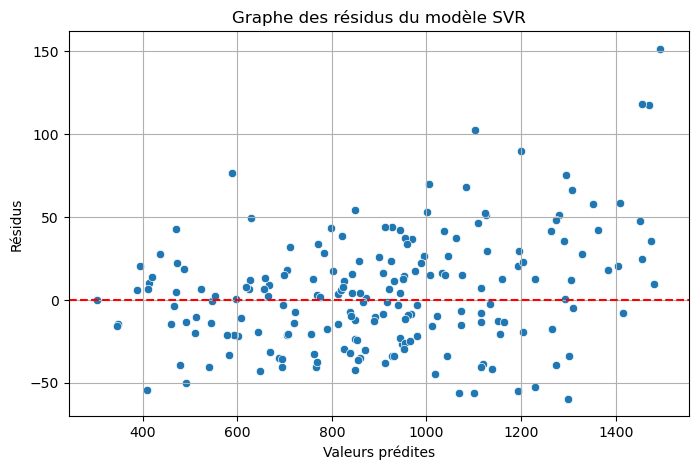

In [17]:
# Prédictions sur les données de test
y_pred = svmOpt.predict(Xr_test)
mse_SVR = mean_squared_error(Y_test, y_pred)

# erreur de prévision sur le test
Q2_SVR= svmOpt.score(Xr_test,Y_test)

# Calcul des résidus
residus = Y_test - y_pred

# Tracé du graphe des résidus
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residus)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphe des résidus du modèle SVR")
plt.grid(True)
plt.show()


On observe bien ici un "effet couloir" sur les résidus de notre modèle SVR, ce qui signifie que les valeurs restent plus ou moins bien (à quelques valeurs près sur les bords) dans le couloir imposé par $\epsilon$.


## Arbre Optimal

Nous considérons ensuite les arbres de décision de type **CART (Classification and Regression Trees)**. Contrairement aux modèles linéaires, un arbre CART segmente l’espace des variables explicatives en sous-régions homogènes selon des règles de décision hiérarchiques.

En régression, un arbre de décision assigne une valeur constante à chaque feuille terminale, correspondant à la moyenne des observations de cette région. Par conséquent, les prédictions du modèle ne peuvent prendre que des valeurs discrètes, limitées au nombre de feuilles générées par l’arbre.


In [18]:
# Optimisation de la profondeur de l'arbre pour un problème de régression
param = [{"max_depth": list(range(2, 10))}]
tree = GridSearchCV(DecisionTreeRegressor(), param, cv=10, n_jobs=-1)
treeOpt = tree.fit(Xr_train, Y_train)

# Affichage du meilleur score (R² ici) et du meilleur paramètre
print("Meilleur score (R²) = %f, Meilleur paramètre = %s" % (treeOpt.best_score_, treeOpt.best_params_))

Meilleur score (R²) = 0.921136, Meilleur paramètre = {'max_depth': 8}


In [19]:
# Estimation de l'erreur de prévision
Q2_DTR=treeOpt.score(Xr_test,Y_test)

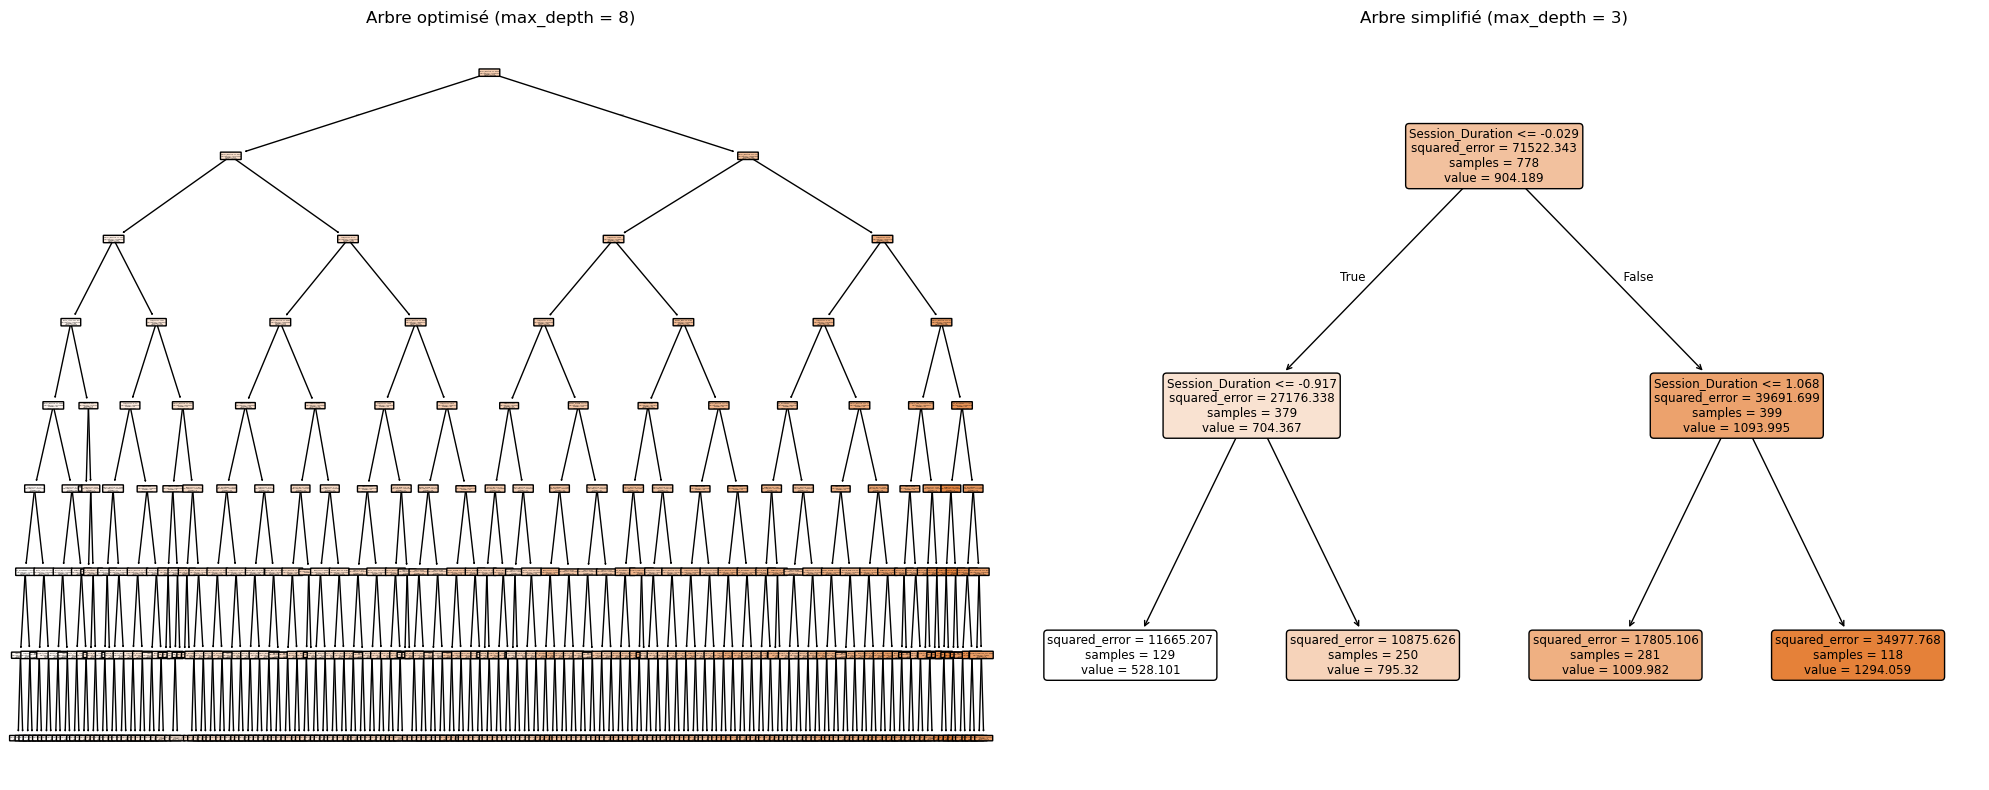

In [20]:
# Arbre optimisé
tree_opt = DecisionTreeRegressor(max_depth=treeOpt.best_params_['max_depth'])
tree_opt.fit(Xr_train, Y_train)

# Arbre simplifié à profondeur 3
tree_depth3 = DecisionTreeRegressor(max_depth=2)
tree_depth3.fit(Xr_train, Y_train)

# Affichage côte à côte
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plot_tree(tree_opt,
          feature_names=dfC.columns.tolist(),
          filled=True,
          rounded=True,
          max_depth=treeOpt.best_params_['max_depth'])
plt.title(f"Arbre optimisé (max_depth = {treeOpt.best_params_['max_depth']})")

plt.subplot(1, 2, 2)
plot_tree(tree_depth3,
          feature_names=dfC.columns.tolist(),
          filled=True,
          rounded=True,
          max_depth=3)
plt.title("Arbre simplifié (max_depth = 3)")

plt.tight_layout()
plt.show()

L’arbre obtenu a une profondeur de 8, ce qui le rend difficile à interpréter en raison de la complexité des règles de séparation. 

Pour illustrer le fonctionnement général de ce type de modèle, nous avons restreint l’affichage à une profondeur de 3. On observe que les premières décisions sont, une fois de plus, principalement basées sur la variable session_duration.

In [21]:
def get_leaf_paths(tree, feature_names):
    paths = []

    def recurse(node_id=0, path=[]):
        if tree.children_left[node_id] == -1:  # feuille
            value = tree.value[node_id][0][0]
            n_samples = tree.n_node_samples[node_id]
            paths.append((n_samples, value, path))
        else:
            feature = feature_names[tree.feature[node_id]]
            threshold = tree.threshold[node_id]
            recurse(tree.children_left[node_id], path + [f"{feature} <= {threshold:.3f}"])
            recurse(tree.children_right[node_id], path + [f"{feature} > {threshold:.3f}"])

    recurse()
    return paths

# Récupère les informations de l’arbre
tree_structure = tree_opt.tree_
feature_names = dfC.columns.tolist()

# Récupère tous les chemins vers les feuilles
paths = get_leaf_paths(tree_structure, feature_names)

# Trie par nombre d’échantillons décroissant
top_paths = sorted(paths, key=lambda x: -x[0])[:3]

# Affiche les 3 chemins les plus fréquentés
for i, (n_samples, value, rules) in enumerate(top_paths):
    print(f"Chemin {i+1}:")
    for condition in rules:
        print(f"    {condition}")
    print(f"  => Prédiction: {value:.3f} avec {n_samples} échantillons\n")

Chemin 1:
    Session_Duration > -0.029
    Session_Duration <= 1.068
    Avg_BPM <= 0.396
    Avg_BPM > -0.923
    Gender_Female <= 0.062
    Fat_Percentage > -2.138
    Age <= 0.151
    Session_Duration <= 0.475
  => Prédiction: 1008.909 avec 22 échantillons

Chemin 2:
    Session_Duration <= -0.029
    Session_Duration > -0.917
    Avg_BPM > -0.229
    Session_Duration <= -0.503
    Avg_BPM <= 1.508
    Age > -0.215
    Water_Intake <= 0.213
    Max_BPM <= 1.234
  => Prédiction: 720.947 avec 19 échantillons

Chemin 3:
    Session_Duration > -0.029
    Session_Duration <= 1.068
    Avg_BPM > 0.396
    Gender_Male > -0.062
    Session_Duration > 0.357
    Age > -0.011
    Fat_Percentage > -1.850
    Height (m) <= 1.892
  => Prédiction: 1162.267 avec 15 échantillons



Nous avons également visualisé les trois chemins les plus fréquemment empruntés par les données d’apprentissage dans l’arbre optimal. Ces trajectoires mettent en évidence des variables récurrentes telles que la durée de la session ou le BPM moyen, qui jouent un rôle clé dans les décisions du modèle.

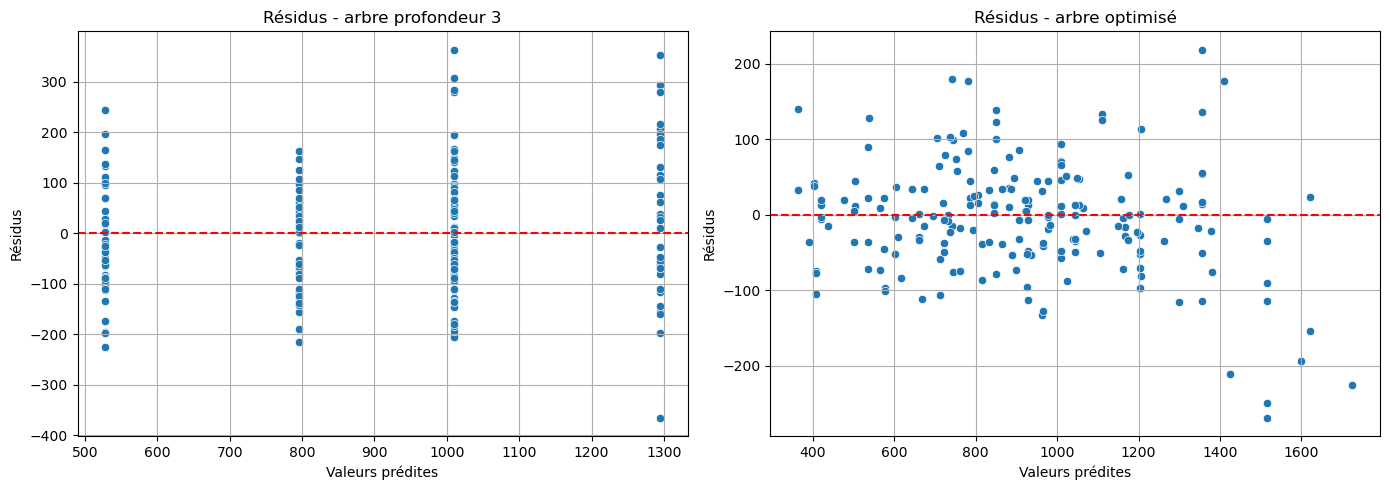

In [22]:
# Prédictions pour les deux modèles
y_pred_depth3 = tree_depth3.predict(Xr_test)
y_pred_opt = tree_opt.predict(Xr_test)

# Résidus
residus_depth3 = Y_test - y_pred_depth3
residus_opt = Y_test - y_pred_opt

mse_CART = mean_squared_error(Y_test, y_pred_opt)

# Tracé côte à côte
plt.figure(figsize=(14, 5))

# Graphe pour tree_depth3
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_depth3, y=residus_depth3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Résidus - arbre profondeur 3")
plt.grid(True)

# Graphe pour tree_opt
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_opt, y=residus_opt)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Résidus - arbre optimisé")
plt.grid(True)

plt.tight_layout()
plt.show()


Plus l’arbre est élagué, plus cela met en évidence une limite propre aux arbres de décision CART en régression : les prédictions produites ne peuvent prendre qu’un nombre fini de valeurs, correspondant aux moyennes dans les feuilles terminales. Cela se traduira par la suite par une MSE plus grande que pour les autres modèles. Toutes les valeurs comprises dans un certain intervalle auront la même prédiction, ainsi même si le modèle est très bon l'erreur sera nécessairement plus grande puisqu'il est très difficile de prédire exactement la bonne valeur.

## Forêt aléatoire

La RandomForest est une méthode d’agrégation d’arbres de décision qui améliore la performance et la robustesse des modèles individuels, notamment ceux de type CART. Elle construit un grand nombre d’arbres indépendants à partir d’échantillons aléatoires des données (bootstrap), en introduisant de l’aléa également dans le choix des variables utilisées à chaque séparation. En régression, la prédiction finale est obtenue par la moyenne des prédictions de chaque arbre.

In [23]:
param=[{"max_features":list(range(2,10,1))}]
rf= GridSearchCV(RandomForestRegressor(n_estimators=100),
        param,cv=5,n_jobs=-1)
rfOpt=rf.fit(Xr_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

Meilleur score = 0.040101, Meilleur paramètre = {'max_features': 9}


In [24]:
# erreur de prévision sur le test
Q2_RFR=rfOpt.score(Xr_test,Y_test)
y_pred = rfOpt.predict(Xr_test)
mse_RFR = mean_squared_error(Y_test, y_pred)

## Boosting

Le Gradient Boosting est une méthode d’assemblage itérative qui construit un modèle prédictif en combinant plusieurs arbres de décision faibles (souvent peu profonds). Chaque nouvel arbre est entraîné pour corriger les erreurs résiduelles des modèles précédents, en optimisant une fonction de perte via une descente de gradient. Ce procédé permet de réduire progressivement l’erreur du modèle global.
Le gradient boosting est très performant pour capturer des relations complexes, mais nécessite un réglage fin des hyperparamètres pour éviter le surapprentissage.


In [25]:
tps0=time.perf_counter()
param=[{"n_estimators":[200, 250, 300]}]
gbm= GridSearchCV(GradientBoostingRegressor(),param,cv=10)
gbmOpt=gbm.fit(Xr_train, Y_train)
# paramètre optimal
tps1=(time.perf_counter()-tps0)
print("Temps boosting = %f, Meilleur taux = %f, Meilleur paramètre = %s" % (tps1,
                        1. - gbmOpt.best_score_,gbmOpt.best_params_))

Temps boosting = 9.115340, Meilleur taux = 0.005150, Meilleur paramètre = {'n_estimators': 300}


In [26]:
# erreur de prévision sur le test
Q2_GBR=gbmOpt.score(Xr_test,Y_test)
y_pred = gbmOpt.predict(Xr_test)
mse_GBR=mean_squared_error(Y_test, y_pred)

## Réseaux de neuronnes

Les réseaux de neurones sont des modèles inspirés du fonctionnement biologique du cerveau, composés de couches de neurones artificiels interconnectés. Chaque neurone effectue une transformation non linéaire de la somme pondérée de ses entrées, ce qui permet au réseau de modéliser des relations complexes et non linéaires entre les variables.

Pour une couche simple, la sortie pour une observation $X_i$ s’écrit :

$$
h = \sigma \left( W X_i + b \right)
$$

où $W$ est la matrice des poids, $b$ le vecteur de biais, et $\sigma$ une fonction d’activation non linéaire (comme sigmoïde par exemple). En combinant plusieurs couches, le réseau apprend à extraire des représentations hiérarchiques des données, ce qui explique sa puissance dans de nombreux domaines.

In [27]:
param_grid=[{"hidden_layer_sizes":list([(5,),(10,),(50,),(70,),(5,5,5),(100, 100),(70, 70),(50, 50, 50),(30,30,30)])}]
nnet= GridSearchCV(MLPRegressor(max_iter=100000),param_grid,cv=10,n_jobs=-1)
nnetOpt=nnet.fit(Xr_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - nnetOpt.best_score_,nnetOpt.best_params_))

Meilleur score = 0.016412, Meilleur paramètre = {'hidden_layer_sizes': (70,)}


In [28]:
# Estimation de l'erreur de prévision sur le test
Q2_MLPR=nnetOpt.score(Xr_test,Y_test)
y_pred = nnetOpt.predict(Xr_test)
mse_MLPR=mean_squared_error(Y_test, y_pred)

## Comparaison des modèles de regression

Pour comparer les modèles de regression entre eux, mais également avec les autres modèles, nous utiliserons les scores détaillés ci-dessous.

Le R²-ajusté pénalise l’ajout de variables non pertinentes dans le modèle. Il est défini comme :
$$
R^2_{\text{adj}} = 1 - \left( \frac{(1 - R^2)(n - 1)}{n - p - 1} \right)
$$
- $n$ : nombre d'observations
- $p$ : nombre de variables explicatives

Avec:
$$
R^2 = 1 - \frac{SS_{res}}{SS_{tot}}
$$
- $ SS_{res} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $ : somme des carrés des résidus (erreurs du modèle)
- $ SS_{tot} = \sum_{i=1}^{n} (y_i - \bar{y})^2 $ : somme totale des carrés (par rapport à la moyenne)

Le $R^2$ sur les données d'entraînement mesure si le modèle s’adapte aux données qu’il a vues pendant l’apprentissage. Un $R^2$ trop élevé (proche de 1) peut indiquer un surajustage (overfitting) du modèle. 

Le $R^2$ appliqué à l'échantillon test, aussi appelé $Q^2$, mesure la capacité du modèle à généraliser à de nouvelles données. C'est ce score qui sera donc utilisé pour comparer les modèles entre eux pour la regression.

In [29]:
ScoreNonlin = pd.DataFrame({
    "Modèles optimisés": ["Lasso", "SVR","CART","RandomForest","GradientBoosting","Réseau de neurones"],
    "Score Q²": [Q2_Lasso,Q2_SVR,Q2_DTR,Q2_RFR,Q2_GBR,Q2_MLPR],
    "Erreur quadratique moyenne": [mse_Lasso,mse_SVR,mse_CART,mse_RFR,mse_GBR,mse_MLPR]
})

ScoreLin = pd.DataFrame({
    "Modèle": ["Regression Linéaire", "Ridge", "Lasso"],
    "Score Q²": [Q2_LR, Q2_Ridge, Q2_Lasso]
})

# Afficher le tableau
print(ScoreNonlin )

# Afficher le tableau
print(ScoreLin)

    Modèles optimisés  Score Q²  Erreur quadratique moyenne
0               Lasso  0.981380                 1585.233321
1                 SVR  0.985643                 1222.328225
2                CART  0.942039                 5525.011185
3        RandomForest  0.974401                 2179.414446
4    GradientBoosting  0.996535                  295.032628
5  Réseau de neurones  0.989780                  870.094013
                Modèle  Score Q²
0  Regression Linéaire  0.981271
1                Ridge  0.981333
2                Lasso  0.981380


Au sein des méthodes linéaires, toutes les méthodes présentent un $Q^2$ similaire et élevé. Nous retenons toutefois la régression Lasso pour la comparaison avec les autres modèles, en raison de son $Q^2$ très légèrement supérieur.

Parmi les différents modèles d’apprentissage automatique testés, le Gradient Boosting se distingue nettement avec le meilleur score Q² de 0.996531 et la plus faible erreur quadratique moyenne (MSE) de 295.32, indiquant une capacité prédictive exceptionnelle.

Il est suivi de près par le réseau de neurones (Q² = 0.985125, MSE = 1266.41) et le SVR (Q² = 0.985643, MSE = 1222.33), qui affichent eux aussi d’excellentes performances, traduisant une forte aptitude à généraliser sur des données non vues.

Le modèle Lasso, avec un score Q² de 0.981380 et une MSE de 1585.23, reste performant tout en offrant une meilleure interprétabilité, ce qui peut être un atout dans certains contextes.

Le Random Forest, bien qu’efficace (Q² = 0.974003, MSE = 2213.30), montre une légère perte de précision par rapport aux méthodes plus sophistiquées.

Enfin, le modèle CART (Classification and Regression Tree) affiche le score le plus faible (Q² = 0.940134) et la plus forte erreur (MSE = 4815.61), ce qui suggère qu’il pourrait souffrir de limitations liées à sa simplicité.

Globalement, cette comparaison met en lumière la supériorité des approches ensemblistes et profondes pour cette tâche spécifique

# Prévision du niveau d'experience

Nous nous intéressons ici à la prédiction du niveau d'expérience, une variable qualitative comportant trois modalités : débutant, intermédiaire et avancé. Pour identifier le modèle le plus performant, nous comparerons différentes méthodes de classification. Nous utilisons globalement les mêmes modèles que précédemment, cette fois dans leur version adaptée à la classification. Par conséquent, nous ne reviendrons pas en détail sur le fonctionnement de chacun d’eux.

On effectue le même processus de One-Hot encoding que pour la prevision des calories brûlées.

In [66]:
GymDum=pd.get_dummies(Gym[["Gender","Workout_Type","Experience_Level","Workout_Frequency"]])
GymDum = GymDum.drop(columns=["Workout_Type_Cardio","Workout_Frequency_2"])


GymDum2=pd.get_dummies(Gym[["Gender","Workout_Type","Workout_Frequency"]])
GymDum2 = GymDum2.drop(columns=["Workout_Type_Cardio","Workout_Frequency_2"])


Y1=GymDum["Experience_Level_1"]
Y2=GymDum["Experience_Level_2"]
Y3=GymDum["Experience_Level_3"]

Yb=Gym["Experience_Level"]

Y3.head()

0     True
1    False
2    False
3    False
4    False
Name: Experience_Level_3, dtype: bool

In [64]:
dfC2=pd.concat([GymDum,GymQuant],axis=1)
dfC2=dfC2.drop(columns=["Experience_Level_1","Experience_Level_2", "Experience_Level_3"]) 

dfC3=pd.concat([GymDum2,GymQuant],axis=1)

dfC2.head()

,Gender_Female,Gender_Male,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga,Workout_Frequency_3,Workout_Frequency_4,Workout_Frequency_5,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Calories_Burned,Fat_Percentage,BMI,Session_Duration,Water_Intake
0,False,True,False,False,True,False,True,False,56,88.3,1.71,180,157,60,1313.0,12.6,5.495453,1.69,3.5
1,True,False,True,False,False,False,True,False,46,74.9,1.53,179,151,66,883.0,33.9,5.656854,1.30,2.1
2,True,False,False,False,False,False,True,False,32,68.1,1.66,167,122,54,677.0,33.4,4.970915,1.11,2.3
3,False,True,False,True,False,True,False,False,25,53.2,1.70,190,164,56,532.0,28.8,4.290688,0.59,2.1
4,False,True,False,True,False,True,False,False,38,46.1,1.79,188,158,68,556.0,29.2,3.793415,0.64,2.8


## Séparation de la base en train/test

Certaines méthodes de classification, telles que la régression logistique (que nous détaillerons ultérieurement) ne sont conçues que pour gérer des problèmes à deux classes. Or, notre variable cible « niveau d’expérience » comporte trois modalités (débutant, intermédiaire, avancé) ce qui la rend multiclasse. Afin de pouvoir appliquer ces modèles binaires, il a donc été nécessaire de reformuler le problème en créant trois jeux de données distincts. Chacun de ces jeux considère une modalité spécifique comme la classe positive (encodée en 1), tandis que les deux autres sont regroupées et encodées en 0. Cette approche, souvent appelée binarisation en un contre tous (one-vs-rest), permet d’adapter les modèles binaires à un contexte multiclasse.

In [32]:
X1_train,X1_test,Y1_train,Y1_test=train_test_split(dfC2,Y1,test_size=0.2,random_state=11)
X2_train,X2_test,Y2_train,Y2_test=train_test_split(dfC2,Y2,test_size=0.2,random_state=11)
X3_train,X3_test,Y3_train,Y3_test=train_test_split(dfC2,Y3,test_size=0.2,random_state=11)
X_train,X_test,Yb_train,Yb_test=train_test_split(dfC3,Yb,test_size=0.2,random_state=11)

Il est nécessaire comme précedemment de réaliser au préalable une normalisation des données.

In [33]:
# Normalisation des variables explicatives
scaler = StandardScaler()  
scaler.fit(X1_train)  
scaler.fit(X2_train)  
scaler.fit(X3_train)  
scaler.fit(X_train)  

Xb1_train = scaler.fit_transform(X1_train)  
Xb1_test = scaler.transform(X1_test)
Xb2_train = scaler.fit_transform(X2_train)  
Xb2_test = scaler.transform(X2_test)
Xb3_train = scaler.fit_transform(X3_train)  
Xb3_test = scaler.transform(X3_test)
Xb_train = scaler.fit_transform(X_train)  
Xb_test = scaler.transform(X_test)

## Modèle linéaire (Régression logistique)

Pour la classification, le modèle linéaire utilisé est la régression logistique. Toutefois, celui-ci étant conçu pour des tâches de classification binaire, il a été nécessaire de l’appliquer séparément à chaque modalité du niveau d’expérience.

#### Niveau 1 d'Expérience Level (débutant)

In [34]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
param=[{"C":[1,1.2,1.5,1.7,2,3,4]}]
logit = GridSearchCV(LogisticRegression(penalty="l1",solver="liblinear"), param,cv=5,n_jobs=-1)
logitOpt1=logit.fit(Xb1_train, Y1_train)  # GridSearchCV est lui-même un estimateur
# paramètre optimal
logitOpt1.best_params_["C"]
print("Meilleur score = %f, Meilleur paramètre = %s" % (1.-logitOpt1.best_score_,logitOpt1.best_params_))
# erreur sur l'échantillon test
1-logitOpt1.score(Xb1_test, Y1_test)

Meilleur score = 0.124673, Meilleur paramètre = {'C': 1.2}


0.1282051282051282

In [35]:
# Prévision
y_chap1 = logitOpt1.predict(Xb1_test)
# matrice de confusion
table=pd.crosstab(y_chap1,Y1_test)
print(table)

accuracy = np.trace(table.values) / table.values.sum()
print("Accuracy:", accuracy)

Experience_Level_1  False  True 
row_0                           
False                 105     13
True                   12     65
Accuracy: 0.8717948717948718


L’objectif est de prédire si un utilisateur appartient au niveau d’expérience 1 à l’aide d’un modèle de classification binaire. On évalue la performance du modèle à l’aide d’une matrice de confusion, avec les résultats suivants :

Vrais positifs (TP) : 65 \
Faux positifs (FP) : 13\
Faux négatifs (FN) : 12\
Vrais négatifs (TN) : 105

Le taux de validité de cette matrice de confusion étant de 0,87, nous pouvons considérer que le modèle sait bien prédire les individus ayant un niveau d'expérience égal à 1. 


In [36]:
# Coefficients
logitLasso1=LogisticRegression(penalty="l1",C=logitOpt1.best_params_['C'],
                              solver="liblinear")
logitCoef1=logitLasso1.fit(Xb1_train,Y1_train).coef_

coef1 = pd.Series(logitCoef1[0], index = X1_train.columns)
print("Lasso conserve " + str(sum(coef1 != 0)) + 
      " variables et en supprime " +  str(sum(coef1 == 0)))

coef_df1 = pd.Series(logitCoef1[0], index=X1_train.columns)
print(coef_df1)
print('')
print("Variables avec coefficient nul (éliminées par Lasso) :")
print(coef_df1[coef_df1 == 0])


Lasso conserve 17 variables et en supprime 2
Gender_Female            0.035300
Gender_Male             -0.040828
Workout_Type_HIIT        0.000000
Workout_Type_Strength    0.047504
Workout_Type_Yoga       -0.178952
Workout_Frequency_3     -2.663452
Workout_Frequency_4     -5.105737
Workout_Frequency_5     -2.478992
Age                      0.021649
Weight (kg)              0.000000
Height (m)               0.062281
Max_BPM                 -0.071014
Avg_BPM                  0.228220
Resting_BPM             -0.110631
Calories_Burned         -0.973359
Fat_Percentage           0.044884
BMI                     -0.003465
Session_Duration        -0.741921
Water_Intake             0.086741
dtype: float64

Variables avec coefficient nul (éliminées par Lasso) :
Workout_Type_HIIT    0.0
Weight (kg)          0.0
dtype: float64


Text(0.5, 1.0, 'Coefficients du modèle lasso')

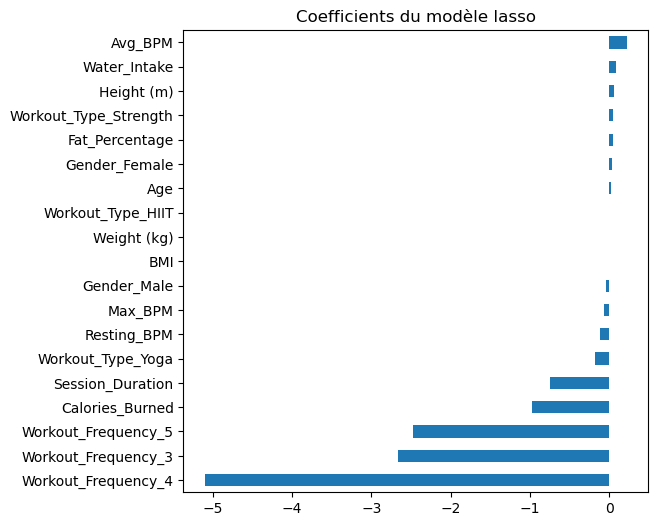

In [37]:
imp_coef = coef1.sort_values()
plt.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

Les variables Workout_Type_HIIT, Weight (kg) et Gender_Female ont un coefficient nul, ce qui signifie que le modèle ne les considère pas comme informatives pour la prédiction, compte tenu des autres variables disponibles. Ces variables sont donc éliminées automatiquement par la régularisation L1. Cela peut signifier qu’elles n’apportent pas d’information discriminante une fois les autres variables prises en compte, ou qu’elles sont fortement corrélées à des variables déjà présentes.

Il est important de noter que dans ce modèle, les modalités de référence sont Workout_Type_Cardio pour le type d’entraînement et Workout_Frequency_2 pour la fréquence d’entraînement. Cela signifie que tous les coefficients associés aux autres modalités de ces variables doivent être interprétés par rapport à ces catégories de base.

Par exemple, Workout_Frequency_4 a un coefficient de -5.10, ce qui indique que s’entraîner 4 fois par semaine est fortement négativement associé à la probabilité d’appartenir au niveau 1 de l’Experience_Level, comparé à la fréquence de 2 fois par semaine. Autrement dit, une fréquence d'entraînement de 4 fois par semaine réduit fortement la probabilité d’être débutant par rapport à une fréquence de 2 fois.

De manière cohérente, les autres fréquences d'entraînement modérées à élevées (Workout_Frequency_3 et Workout_Frequency_5) présentent également des coefficients négatifs, ce qui suggère que ces fréquences sont aussi associées à un niveau d’expérience plus élevé que la fréquence de 2 fois par semaine.

Par ailleurs, la durée de la session (Session_Duration) et le nombre de calories brûlées (Calories_Burned) ont des coefficients négatifs, ce qui indique qu'une augmentation de ces valeurs est associée à une probabilité plus faible d’être dans le niveau 1 d’expérience (i.e., d’être débutant), comparativement aux individus effectuant des séances de type cardio deux fois par semaine (les modalités de référence).

Autrement dit, les individus qui s'entraînent plus longtemps et brûlent plus de calories ont tendance à ne pas être débutants, ce qui est cohérent avec le fait qu’une meilleure condition physique, une endurance plus élevée et des efforts plus soutenus sont caractéristiques de pratiquants plus expérimentés.

#### Niveau 2 d'Expérience Level (intermédiaire)

In [38]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
param=[{"C":[1,1.2,1.5,1.7,2,3,4]}]
logit2 = GridSearchCV(LogisticRegression(penalty="l1",solver="liblinear"), param,cv=5,n_jobs=-1)
logitOpt2=logit2.fit(Xb2_train, Y2_train)  # GridSearchCV est lui-même un estimateur
# paramètre optimal
logitOpt2.best_params_["C"]
print("Meilleur score = %f, Meilleur paramètre = %s" % (1.-logitOpt2.best_score_,logitOpt2.best_params_))

# erreur sur l'échantillon test
1-logitOpt2.score(Xb2_test, Y2_test)

Meilleur score = 0.167047, Meilleur paramètre = {'C': 1}


0.16410256410256407

In [39]:
# Prévision
y_chap2 = logitOpt2.predict(Xb2_test)
# matrice de confusion
table=pd.crosstab(y_chap2,Y2_test)
print(table)

accuracy = np.trace(table.values) / table.values.sum()
print("Accuracy:", accuracy)

Experience_Level_2  False  True 
row_0                           
False                 104     17
True                   15     59
Accuracy: 0.8358974358974359


Dans ce nouveau cas, la matrice de confusion a un taux de validité de 83%, c'est légèrement inférieur au taux de validité de la matrice réalisée pour le niveau d'experience 1 ce qui peut sous-entendre que le niveau 2 est un peu moins bien prédit cependant le taux de validité est toujours très bon.

In [40]:
# Coefficients
logitLasso2=LogisticRegression(penalty="l1",C=logitOpt2.best_params_['C'],
                              solver="liblinear")
logitCoef2=logitLasso2.fit(Xb2_train,Y2_train).coef_

coef2 = pd.Series(logitCoef2[0], index = X2_train.columns)
print("Lasso conserve " + str(sum(coef2 != 0)) + 
      " variables et en supprime " +  str(sum(coef2 == 0)))

coef_df2 = pd.Series(logitCoef2[0], index=X2_train.columns)
print(coef_df2)
print('')
print("Variables avec coefficient nul (éliminées par Lasso) :")
print(coef_df2[coef_df2 == 0])


Lasso conserve 15 variables et en supprime 4
Gender_Female           -0.666994
Gender_Male              0.721547
Workout_Type_HIIT        0.011979
Workout_Type_Strength   -0.100250
Workout_Type_Yoga        0.065230
Workout_Frequency_3      2.526033
Workout_Frequency_4      3.578052
Workout_Frequency_5      0.000000
Age                      0.000000
Weight (kg)              0.000000
Height (m)              -0.066396
Max_BPM                  0.032486
Avg_BPM                  0.000000
Resting_BPM              0.009090
Calories_Burned          0.449306
Fat_Percentage           1.958869
BMI                      0.014474
Session_Duration         0.191328
Water_Intake            -0.744354
dtype: float64

Variables avec coefficient nul (éliminées par Lasso) :
Workout_Frequency_5    0.0
Age                    0.0
Weight (kg)            0.0
Avg_BPM                0.0
dtype: float64


Text(0.5, 1.0, 'Coefficients du modèle lasso')

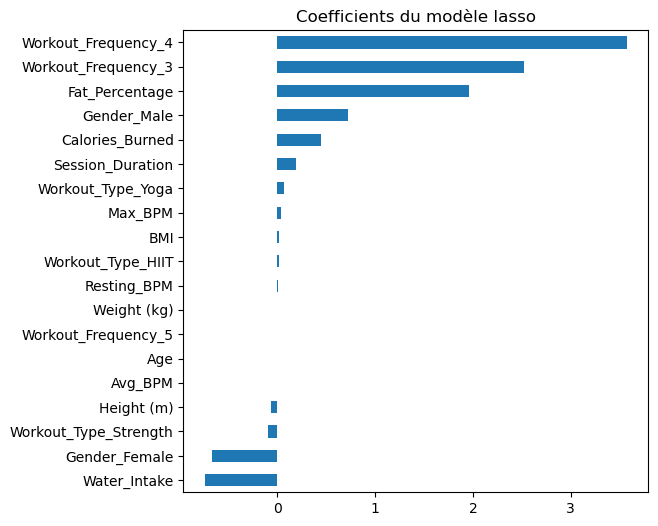

In [41]:
imp_coef2 = coef2.sort_values()
plt.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef2.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

De la même manière que pour le niveau d’expérience 1, certaines variables comme Weight (kg), Age, Workout_Frequency_5 et Avg_BPM ont un coefficient nul, ce qui signifie que le modèle ne les retient pas comme informatives une fois les autres variables prises en compte. Elles sont donc éliminées par la régularisation L1 (lasso), soit parce qu’elles sont redondantes avec d’autres variables, soit parce qu’elles n’ont pas d’effet discriminant net.

Parmi les variables les plus positivement corrélées à l’appartenance au niveau d’expérience 2 (comparé aux individus faisant du cardio deux fois par semaine), on retrouve :

- Workout_Frequency_3 (+2.53) et Workout_Frequency_4 (+3.58) : cela indique que s’entraîner 3 ou 4 fois par semaine est fortement associé à un niveau d’expérience intermédiaire, ce qui suggère une pratique régulière.
- Fat_Percentage (+1.96) : un taux de masse grasse plus élevé est ici positivement associé, ce qui peut sembler contre-intuitif mais pourrait refléter une phase de recomposition corporelle (plus d'entraînement sans encore de perte nette de masse grasse).
- Calories_Burned (+0.45) : une dépense énergétique plus élevée est logique pour un niveau intermédiaire.
- Gender_Male (+0.75) : être un homme est positivement associé à l’expérience 2, tandis que Gender_Female est négativement associé (-0.63). Cela peut refléter un déséquilibre de genre dans cette tranche (par exemple, plus d’hommes atteignant ce niveau, ou un biais lié aux pratiques sportives différentes entre genres).

D’autres variables avec des effets plus modestes mais positifs incluent : Session_Duration (+0.19), Max_BPM (+0.03), et Workout_Type_Yoga (+0.09), ce qui suggère un engagement d’intensité modérée à soutenue et des pratiques diversifiées.

Enfin, Water_Intake a un coefficient négatif (-0.74). Cela peut sembler surprenant, mais il est possible que cela reflète un biais de saisie ou une corrélation indirecte (par exemple, une meilleure hydratation pourrait être plus rigoureusement suivie chez les débutants ou les plus avancés, mais moins chez les intermédiaires).

#### Niveau 3 d'Expérience Level (avancé)

In [42]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
param=[{"C":[1,1.2,1.5,1.7,2,3,4]}]
logit3 = GridSearchCV(LogisticRegression(penalty="l1",solver="liblinear"), param,cv=5,n_jobs=-1)
logitOpt3=logit3.fit(Xb3_train, Y3_train)  # GridSearchCV est lui-même un estimateur
# paramètre optimal
logitOpt3.best_params_["C"]
print("Meilleur score = %f, Meilleur paramètre = %s" % (1.-logitOpt3.best_score_,logitOpt3.best_params_))

# erreur sur l'échantillon test
1-logitOpt3.score(Xb3_test, Y3_test)

Meilleur score = 0.000000, Meilleur paramètre = {'C': 1}


0.0

In [43]:
# Prévision
y_chap3 = logitOpt3.predict(Xb3_test)
# matrice de confusion
table=pd.crosstab(y_chap3,Y3_test)
print(table)

accuracy = np.trace(table.values) / table.values.sum()
print("Accuracy:", accuracy)

Experience_Level_3  False  True 
row_0                           
False                 154      0
True                    0     41
Accuracy: 1.0


On peut voir ici que le modèle arrive à prédire parfaitement les individus ayant un niveau d'experience égal à 3. C'est surement du à des caractéristiques bien précises que ces individus possèdent et qui les distinguent des autres.

In [44]:
# Coefficients
logitLasso3=LogisticRegression(penalty="l1",C=logitOpt3.best_params_['C'],
                              solver="liblinear")
logitCoef3=logitLasso3.fit(Xb3_train,Y3_train).coef_

coef3 = pd.Series(logitCoef3[0], index = X3_train.columns)
print("Lasso conserve " + str(sum(coef3 != 0)) + 
      " variables et en supprime " +  str(sum(coef3 == 0)))

coef_df3 = pd.Series(logitCoef3[0], index=X3_train.columns)
print(coef_df3)
print('')
print("Variables avec coefficient nul (éliminées par Lasso) :")
print(coef_df3[coef_df3 == 0])

Lasso conserve 8 variables et en supprime 11
Gender_Female            0.565567
Gender_Male             -0.930943
Workout_Type_HIIT        0.000000
Workout_Type_Strength    0.000000
Workout_Type_Yoga        0.000000
Workout_Frequency_3     -0.208599
Workout_Frequency_4      0.037055
Workout_Frequency_5      0.495862
Age                      0.000000
Weight (kg)              0.000000
Height (m)               0.000000
Max_BPM                  0.000000
Avg_BPM                  0.000000
Resting_BPM              0.000000
Calories_Burned          0.000000
Fat_Percentage          -4.462858
BMI                      0.000000
Session_Duration         2.090031
Water_Intake             0.016339
dtype: float64

Variables avec coefficient nul (éliminées par Lasso) :
Workout_Type_HIIT        0.0
Workout_Type_Strength    0.0
Workout_Type_Yoga        0.0
Age                      0.0
Weight (kg)              0.0
Height (m)               0.0
Max_BPM                  0.0
Avg_BPM                  0.0
Restin

Text(0.5, 1.0, 'Coefficients du modèle lasso')

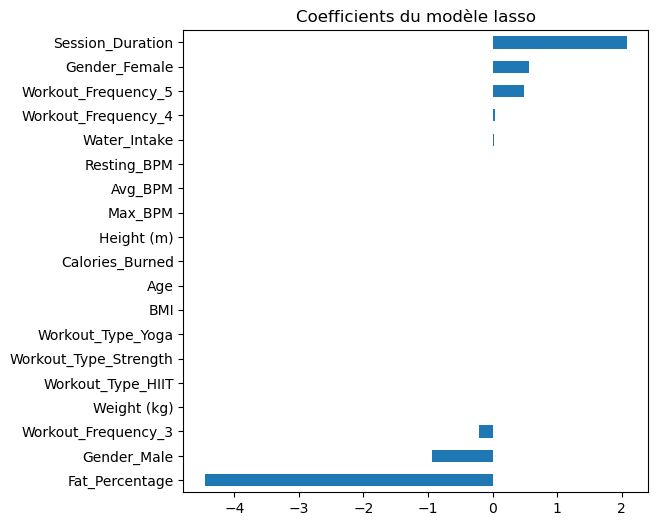

In [45]:
imp_coef3 = coef3.sort_values()
plt.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef3.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

De nombreuses variables ont été écartées par la régularisation Lasso, notamment les types d'entraînement comme le HIIT, la musculation et le yoga, ainsi que des mesures physiologiques (fréquence cardiaque, IMC, poids, taille, âge) et les calories brûlées. Leur absence suggère qu’elles n’apportent pas d’information discriminante supplémentaire par rapport à d’autres variables plus prédictives, comme la durée des sessions ou le taux de masse grasse.

Le modèle est centré autour d’un individu de référence pratiquant le cardio deux fois par semaine, ce qui sert d’intercept. Les coefficients des autres modalités s’interprètent donc relativement à ce profil.

La variable au plus fort impact est le taux de masse grasse, avec un effet négatif très marqué (-4.65). Cela indique que les individus avancés ont tendance à avoir un taux de masse grasse beaucoup plus faible — ce qui est cohérent avec une composition corporelle optimisée typique des sportifs aguerris.

À l’inverse, la durée des sessions a un effet fortement positif (+2.15), suggérant que les pratiquants avancés s'entraînent plus longtemps. Cette intensité et cette structure accrues semblent constituer un facteur clé de différenciation.

Sur le plan du genre, le modèle a conservé à la fois les coefficients Gender_Male (-1.13) et Gender_Female (+0.46). Cela peut indiquer une séparation des comportements ou des performances selon le genre, au-delà de la simple opposition binaire. Ici, être une femme augmente la probabilité d’appartenir au groupe avancé, tandis qu’être un homme la réduit. Cela pourrait refléter une prédominance féminine dans le groupe des sportifs les plus avancés dans cet échantillon, ou des différences marquées dans l’engagement ou le style d'entraînement.

Concernant la fréquence d'entraînement, s'entraîner :

- 3 fois par semaine est modérément positif (+0.51),
- 5 fois par semaine l’est aussi mais un peu moins (+0.21),
- 4 fois par semaine a un effet quasi nul (+0.05),

tandis que 2 fois par semaine (inclus dans l’intercept) est la base de comparaison. Cela souligne qu’un engagement régulier, mais pas nécessairement extrême, est typique des pratiquants avancés.

#### Comparaison avec les trois modalités

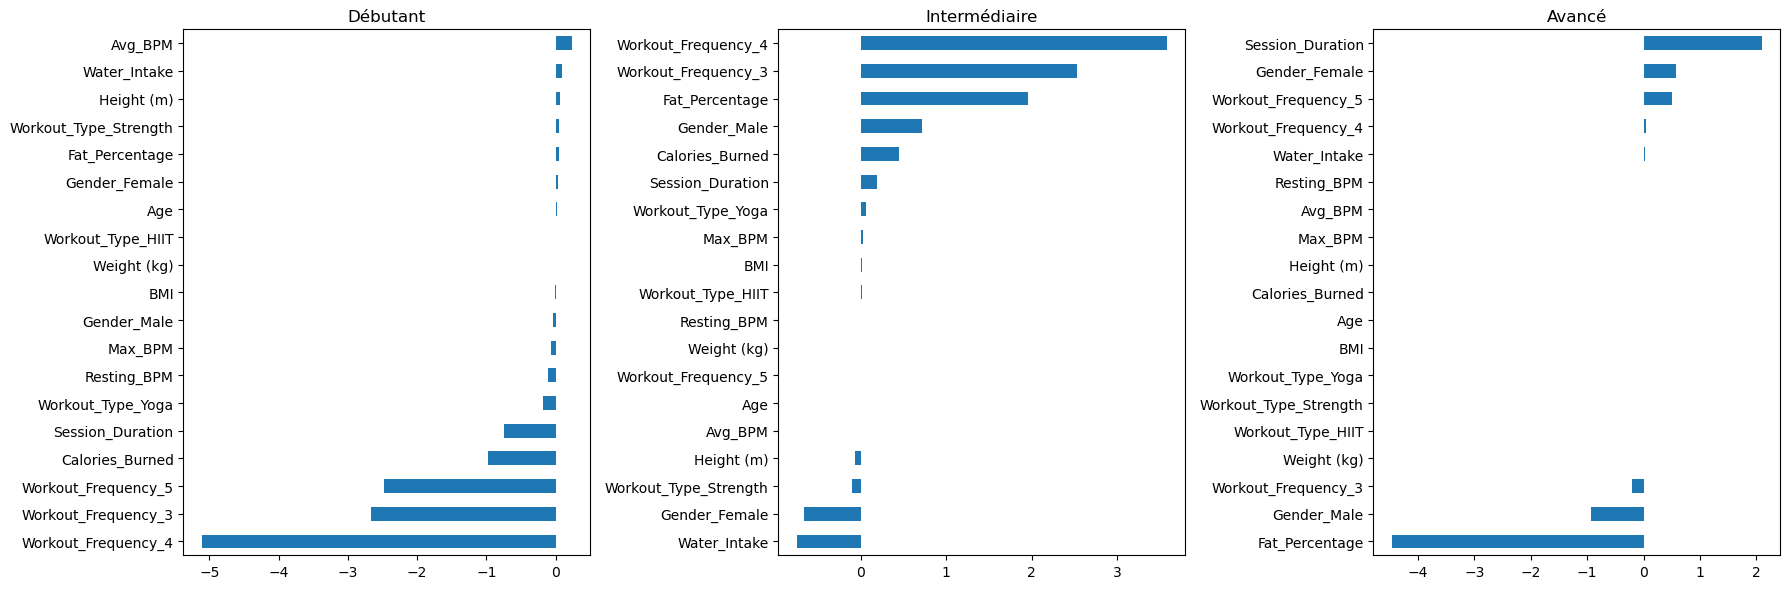

In [46]:
imp_coef1 = coef1.sort_values()
imp_coef2 = coef2.sort_values()
imp_coef3 = coef3.sort_values()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  


imp_coef1.plot(kind="barh", ax=axes[0])
axes[0].set_title("Débutant")

imp_coef2.plot(kind="barh", ax=axes[1])
axes[1].set_title("Intermédiaire")

imp_coef3.plot(kind="barh", ax=axes[2])
axes[2].set_title("Avancé")

plt.tight_layout()
plt.show()

L’analyse des modèles de régression logistique pour chaque niveau d’expérience (Débutant, Intermédiaire, Avancé) met en évidence une évolution claire dans les caractéristiques associées à chaque profil. Il est important de noter que les coefficients sont interprétés relativement à un individu de référence pratiquant le cardio deux fois par semaine.

- Débutants :

Les débutants sont associés à une faible fréquence d’entraînement, notamment 3 ou 4 fois par semaine, avec des coefficients fortement négatifs. Cela indique que ces fréquences d'entraînement réduisent la probabilité d’être classé comme débutant, et donc que ce groupe est principalement constitué de pratiquants ayant une fréquence plus faible ou plus irrégulière.

Ce groupe est aussi caractérisé par des séances plus courtes et une dépense calorique plus faible, traduisant une implication encore modérée dans la pratique sportive. Les variables physiologiques comme la fréquence cardiaque, le poids, l'âge ou la taille sont très peu discriminantes ici, et souvent éliminées par la régularisation Lasso.

- Intermédiaires :

À ce niveau, on observe une transition marquée. Les individus s’entraînent plus régulièrement (3 à 4 fois/semaine) et montrent des signes d’un engagement croissant : augmentation de la durée des séances, plus de calories brûlées, et une masse grasse plus faible.

Le genre masculin est davantage représenté dans ce profil, ce qui peut suggérer des différences comportementales ou une étape plus intermédiaire dans la progression. À noter que le genre est modélisé ici avec les deux modalités (Male et Female) conservées, ce qui permet une lecture plus nuancée de leurs effets.

- Avancés :

Les pratiquants avancés présentent un profil bien distinct, fortement corrélé à des indicateurs d'engagement élevé. Le taux de masse grasse est le facteur le plus discriminant, avec un effet fortement négatif, caractéristique d’une composition corporelle optimisée.

La durée des sessions est le facteur le plus positivement corrélé, ce qui montre un investissement important en temps d’entraînement.

Fait notable, le genre féminin est associé positivement à ce niveau, tandis que le genre masculin est négatif, inversant la tendance observée chez les intermédiaires. Cela pourrait refléter une plus grande constance ou discipline chez certaines pratiquantes, ou des différences structurelles dans l’approche de l’entraînement à haut niveau.

Enfin, la fréquence d’entraînement 5 fois/semaine devient une véritable signature du niveau avancé, tandis que les fréquences intermédiaires (3 ou 4 fois/semaine) n'ont plus de poids discriminant significatif.

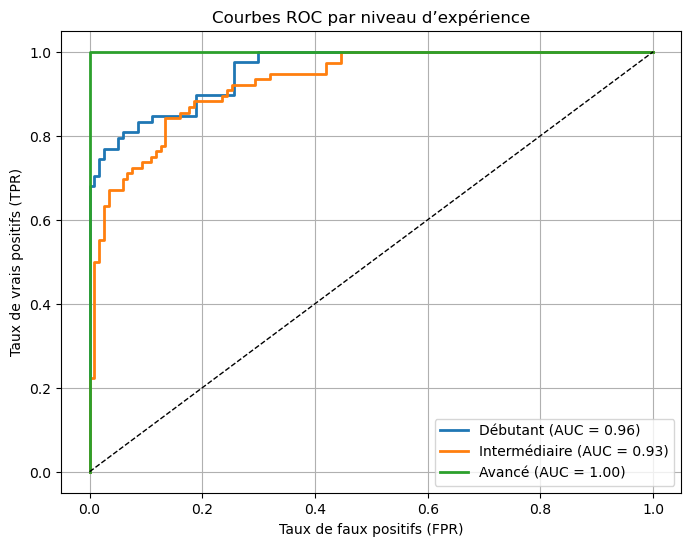

In [47]:
from sklearn.metrics import auc
probas1 = LogisticRegression(penalty="l1", solver="liblinear", 
                             C=logitOpt1.best_params_['C']).fit(X1_train, Y1_train).predict_proba(X1_test)
fpr1, tpr1, _ = roc_curve(Y1_test, probas1[:, 1])
auc1 = auc(fpr1, tpr1)

# Modèle pour niveau Intermédiaire
probas2 = LogisticRegression(penalty="l1", solver="liblinear", 
                             C=logitOpt2.best_params_['C']).fit(X2_train, Y2_train).predict_proba(X2_test)
fpr2, tpr2, _ = roc_curve(Y2_test, probas2[:, 1])
auc2 = auc(fpr2, tpr2)

# Modèle pour niveau Avancé
probas3 = LogisticRegression(penalty="l1", solver="liblinear", 
                             C=logitOpt3.best_params_['C']).fit(X3_train, Y3_train).predict_proba(X3_test)
fpr3, tpr3, _ = roc_curve(Y3_test, probas3[:, 1])
auc3 = auc(fpr3, tpr3)

# Tracer les courbes ROC
plt.figure(figsize=(8,6))
plt.plot(fpr1, tpr1, label=f"Débutant (AUC = {auc1:.2f})", lw=2)
plt.plot(fpr2, tpr2, label=f"Intermédiaire (AUC = {auc2:.2f})", lw=2)
plt.plot(fpr3, tpr3, label=f"Avancé (AUC = {auc3:.2f})", lw=2)
plt.plot([0,1], [0,1], 'k--', lw=1)

plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbes ROC par niveau d’expérience')
plt.legend(loc="lower right")
plt.grid()
plt.show()

L’évaluation des modèles de régression logistique à travers les courbes ROC met en évidence une performance globale très satisfaisante pour chacun des niveaux d’expérience. Le modèle destiné aux débutants atteint une aire sous la courbe (AUC) de 0.96, indiquant une excellente capacité de discrimination. Celui des intermédiaires présente également une bonne performance (AUC = 0.93), bien que légèrement inférieure, suggérant une plus grande variabilité dans ce groupe. Enfin, le modèle associé aux utilisateurs avancés affiche une performance parfaite (AUC = 1.00), ce qui peut révéler une excellente pertinence des variables explicatives. On peut cependant se méfier d'un surapprentissage dans le dernier cas.

## SVM

In [48]:
param=[{"C":[0.4,0.5,0.6,0.8,1,1.4]}]
svm= GridSearchCV(SVC(probability=True),param,cv=10,n_jobs=-1)
svmOpt=svm.fit(Xb_train, Yb_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - svmOpt.best_score_,svmOpt.best_params_))

# erreur de prévision sur le test
accuracy_SVM=svmOpt.score(Xb_test,Yb_test)

Meilleur score = 0.123327, Meilleur paramètre = {'C': 0.4}


In [49]:
# prévision de l'échantillon test
y_chap1 = svmOpt.predict(Xb_test)
# matrice de confusion
table=pd.crosstab(y_chap1,Yb_test)
print("Matrice de confusion: ")
print(table)

print("")
print("")

print("Rapport de classification: ")
print(classification_report(Yb_test, y_chap1))

Matrice de confusion: 
Experience_Level   1   2   3
row_0                       
1                 59  12   0
2                 19  64   0
3                  0   0  41


Rapport de classification: 
              precision    recall  f1-score   support

           1       0.83      0.76      0.79        78
           2       0.77      0.84      0.81        76
           3       1.00      1.00      1.00        41

    accuracy                           0.84       195
   macro avg       0.87      0.87      0.87       195
weighted avg       0.84      0.84      0.84       195



## Arbre optimal CART

In [50]:
# Optimisation de la profondeur de l'arbre
param=[{"max_depth":list(range(2,10))}]
tree= GridSearchCV(DecisionTreeClassifier(),param,cv=10,n_jobs=-1)
treeOpt=tree.fit(Xb_train, Yb_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_,treeOpt.best_params_))

# Estimation de l'erreur de prévision
Accuracy_DTC=treeOpt.score(Xb_test,Yb_test)

Meilleur score = 0.101482, Meilleur paramètre = {'max_depth': 4}


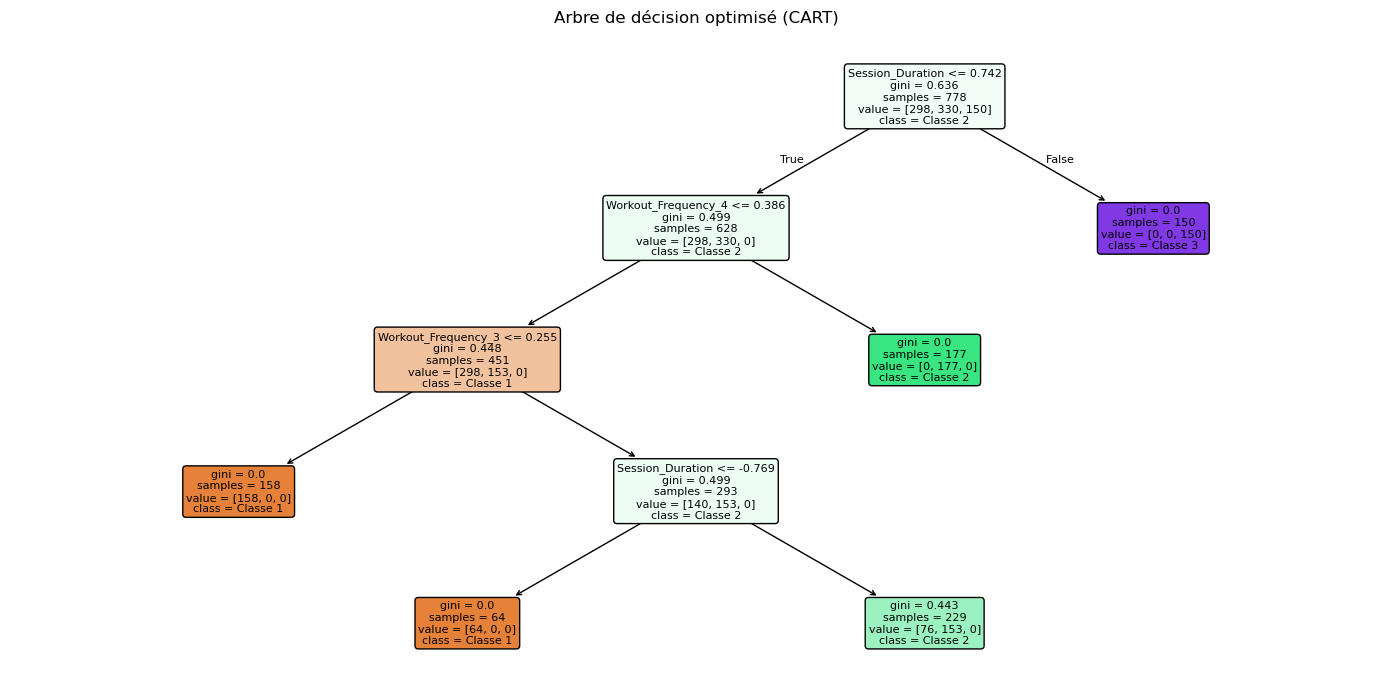

In [75]:
best_tree = treeOpt.best_estimator_


plt.figure(figsize=(14, 7))  # Taille raisonnable
plot_tree(best_tree,
          filled=True,
          feature_names=dfC3.columns,
          class_names=['Classe 1', 'Classe 2', 'Classe 3'],
          rounded=True,
          fontsize=8)

plt.title("Arbre de décision optimisé (CART)", fontsize=12)

# Forcer un bon espacement entre les éléments
plt.subplots_adjust(left=0.01, right=0.99, top=0.95, bottom=0.01)

plt.show()

On observe qu’à l’entraînement, tous les individus de la classe 3 sont immédiatement séparés des autres en fonction de la durée de session. En effet, ils présentent tous une durée supérieure à 0.742 (valeur normalisée), ce qui permet à l’arbre de les regrouper dès les premiers niveaux. Cela explique pourquoi la classe 3 est si bien prédite par la suite sur l'échantillon test.

In [51]:
# prévision de l'échantillon test
y_chap2 = treeOpt.predict(Xb_test)
# matrice de confusion
table=pd.crosstab(y_chap2,Yb_test)
print(table)

print("")
print("")

print("Rapport de classification: ")
print(classification_report(Yb_test, y_chap2))

Experience_Level   1   2   3
row_0                       
1                 60   0   0
2                 18  76   0
3                  0   0  41


Rapport de classification: 
              precision    recall  f1-score   support

           1       1.00      0.77      0.87        78
           2       0.81      1.00      0.89        76
           3       1.00      1.00      1.00        41

    accuracy                           0.91       195
   macro avg       0.94      0.92      0.92       195
weighted avg       0.93      0.91      0.91       195



## Forêt aléatoire

In [53]:
param=[{"max_features":list(range(2,10,1))}]
rf= GridSearchCV(RandomForestClassifier(n_estimators=100),
        param,cv=5,n_jobs=-1)
rfOpt=rf.fit(Xb_train, Yb_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

# erreur de prévision sur le test
accuracy_RFR=rfOpt.score(Xb_test,Yb_test)

Meilleur score = 0.109239, Meilleur paramètre = {'max_features': 5}


In [54]:
# prévision
y_chap3 = rfOpt.predict(Xb_test)
# matrice de confusion
table=pd.crosstab(y_chap3,Yb_test)
print(table)

print("")
print("")

print("Rapport de classification: ")
print(classification_report(Yb_test, y_chap3))

Experience_Level   1   2   3
row_0                       
1                 62   7   0
2                 16  69   0
3                  0   0  41


Rapport de classification: 
              precision    recall  f1-score   support

           1       0.90      0.79      0.84        78
           2       0.81      0.91      0.86        76
           3       1.00      1.00      1.00        41

    accuracy                           0.88       195
   macro avg       0.90      0.90      0.90       195
weighted avg       0.89      0.88      0.88       195



## Boosting

In [55]:
tps0=time.perf_counter()
param=[{"n_estimators":[200, 250, 300]}]
gbm= GridSearchCV(GradientBoostingClassifier(),param,cv=10)
gbmOpt=gbm.fit(Xb_train, Yb_train)
# paramètre optimal
tps1=(time.perf_counter()-tps0)
print("Temps boosting = %f, Meilleur taux = %f, Meilleur paramètre = %s" % (tps1,
                        1. - gbmOpt.best_score_,gbmOpt.best_params_))

# erreur de prévision sur le test
accuracy_GBC=gbmOpt.score(Xb_test,Yb_test)

Temps boosting = 32.220905, Meilleur taux = 0.114386, Meilleur paramètre = {'n_estimators': 200}


In [56]:
# prévision de l'échantillon test
y_chap4 = gbmOpt.predict(Xb_test)
# matrice de confusion
table=pd.crosstab(y_chap4,Yb_test)
print(table)

print("")
print("")

print("Rapport de classification: ")
print(classification_report(Yb_test, y_chap4))

Experience_Level   1   2   3
row_0                       
1                 62   7   0
2                 16  69   0
3                  0   0  41


Rapport de classification: 
              precision    recall  f1-score   support

           1       0.90      0.79      0.84        78
           2       0.81      0.91      0.86        76
           3       1.00      1.00      1.00        41

    accuracy                           0.88       195
   macro avg       0.90      0.90      0.90       195
weighted avg       0.89      0.88      0.88       195



## Réseaux de neuronne

In [57]:
param_grid=[{"hidden_layer_sizes":list([(5,),(6,),(7,),(8,)])}]
nnet= GridSearchCV(MLPClassifier(max_iter=10000),param_grid,cv=10,n_jobs=-1)
nnetOpt=nnet.fit(Xb_train, Yb_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - nnetOpt.best_score_,nnetOpt.best_params_))

# Estimation de l'erreur de prévision sur le test
accuracy_MLPC=nnetOpt.score(Xb_test,Yb_test)

Meilleur score = 0.124642, Meilleur paramètre = {'hidden_layer_sizes': (5,)}


In [58]:
# prévision de l'échantillon test
y_chap5 = nnetOpt.predict(Xb_test)
# matrice de confusion
table=pd.crosstab(y_chap5,Yb_test)
print(table)

print("")
print("")

print("Rapport de classification: ")
print(classification_report(Yb_test, y_chap5))

Experience_Level   1   2   3
row_0                       
1                 63  14   0
2                 15  62   0
3                  0   0  41


Rapport de classification: 
              precision    recall  f1-score   support

           1       0.82      0.81      0.81        78
           2       0.81      0.82      0.81        76
           3       1.00      1.00      1.00        41

    accuracy                           0.85       195
   macro avg       0.87      0.87      0.87       195
weighted avg       0.85      0.85      0.85       195



## Comparaison des méthodes

### Courbe ROC

In [59]:
listMethod=[["SVM",svmOpt],["CART",treeOpt],["RandomForest",rfOpt],["GradientBoosting",gbmOpt],["Réseau de neuronne",nnetOpt]]

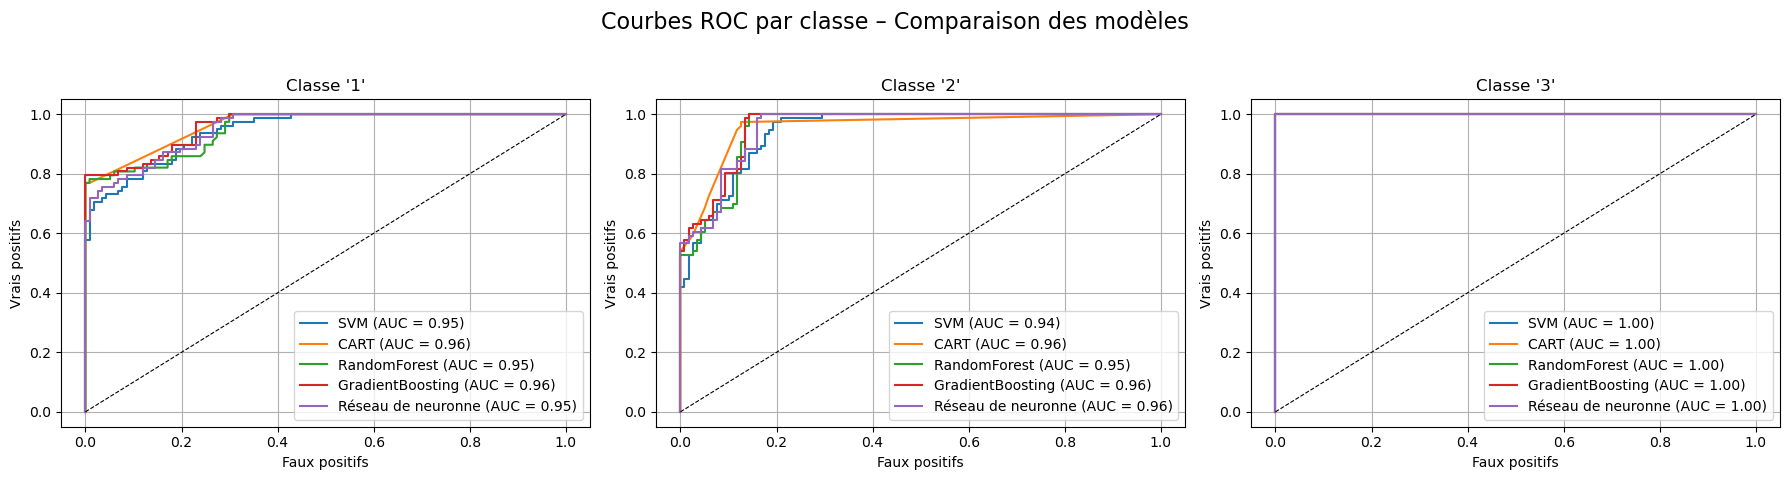

In [60]:
# Supprimer les warnings
warnings.filterwarnings('ignore')

# Encodage des classes 
le = LabelEncoder()
Yb_train_enc = le.fit_transform(Yb_train)
Yb_test_enc = le.transform(Yb_test)
classes = le.classes_  # ['high', 'low', 'medium'] par exemple

# Binarisation des classes test (pour One-vs-Rest)
Yb_test_bin = label_binarize(Yb_test_enc, classes=range(len(classes)))

# Création des sous-graphes
fig, axes = plt.subplots(1, len(classes), figsize=(18, 5))

for i, class_label in enumerate(classes):
    ax = axes[i]
    for name, model in listMethod:
        clf = OneVsRestClassifier(model)
        clf.fit(Xb_train, Yb_train_enc)
        probas_ = clf.predict_proba(Xb_test)

        fpr, tpr, _ = roc_curve(Yb_test_bin[:, i], probas_[:, i])
        auc_score = auc(fpr, tpr)

        ax.plot(fpr, tpr, lw=1.5, label=f"{name} (AUC = {auc_score:.2f})")

    ax.plot([0, 1], [0, 1], 'k--', lw=0.8)
    ax.set_xlabel("Faux positifs")
    ax.set_ylabel("Vrais positifs")
    ax.set_title(f"Classe '{class_label}'")
    ax.legend(loc="lower right")
    ax.grid(True)

plt.suptitle("Courbes ROC par classe – Comparaison des modèles", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Les courbes ROC permettent de visualiser la performance des modèles en termes de compromis entre vrais positifs et faux positifs pour chaque classe.

Pour la classe 1, les modèles CART, GradientBoosting, et RandomForest affichent des AUC très élevés (≈0.96), supérieurs ou équivalents à ceux du SVM et du réseau de neurones (AUC = 0.95), ce qui témoigne d'une bonne capacité à différencier cette classe.

Pour la classe 2, tous les modèles maintiennent de bonnes performances, avec des AUC allant de 0.94 (SVM) à 0.96 (CART, GradientBoosting, Réseau de neurones). Le CART semble particulièrement performant ici également.

Pour la classe 3, tous les modèles atteignent une AUC parfaite de 1.00, ce qui signifie qu’ils arrivent à séparer parfaitement cette classe des autres dans l’échantillon test.

Ainsi, tous les modèles ont une très bonne capacité discriminante globale, mais CART et GradientBoosting se démarquent légèrement avec des AUC constamment élevés. Cela recoupe les résultats de notre ACP, où la classe 3 apparaissait déjà comme mieux définie et plus facilement prédite que les autres.

### Accuracy

In [62]:
Accuracy = pd.DataFrame({
    "Modèle": ["SVM", "CART", "RandomForest","Boosting","Réseaux de neuronne"],
    "Accuracy": [accuracy_SVM, Accuracy_DTC, accuracy_RFR, accuracy_GBC, accuracy_MLPC]
})

print(Accuracy)

                Modèle  Accuracy
0                  SVM  0.841026
1                 CART  0.907692
2         RandomForest  0.882051
3             Boosting  0.882051
4  Réseaux de neuronne  0.851282


L’accuracy globale varie entre 0.84 et 0.91 selon les modèles :

Le CART est le meilleur modèle en termes d’accuracy (0.9077), ce qui corrobore ses excellentes performances observées sur les courbes ROC.
RandomForest et Boosting suivent de près (≈0.88), avec des résultats très compétitifs.
Le réseau de neurones (MLPClassifier) obtient une accuracy correcte de 0.85, bien qu’un peu inférieure à d'autres modèles malgré des courbes ROC très bonnes.
Le SVM a la plus faible accuracy (0.841), ce qui pourrait indiquer une moins bonne performance générale sur la classification multi-classe, malgré des AUC honorables.

Les courbes ROC et les accuracy mènent à des conclusions cohérentes :
Le modèle CART combine une excellente capacité discriminante (AUC élevée) avec la meilleure accuracy globale, ce qui en fait le modèle le plus performant ici.
Les modèles RandomForest et GradientBoosting montrent aussi un équilibre robuste entre AUC et précision globale, tandis que le réseau de neurones, bien qu’efficace pour certaines classes (classe 3), reste légèrement moins fiable en termes d’accuracy globale. Enfin, le SVM, bien que correct, semble en retrait sur ce jeu de données.

# Conclusion